# Word-Level Text Generation

## Setup

In [45]:
!pip install fastai2

from fastai2.text.all import *
from pathlib import Path
import urllib.request
import warnings

## Text

In [63]:
# to clean, run !rm -rf data dta_tok
Path("data").mkdir(exist_ok=True)
urllib.request.urlretrieve("https://s3.amazonaws.com/text-datasets/nietzsche.txt", "data/nietzsche.txt")
# Other possible text datasets
# Shakespare sonnets, https://raw.githubusercontent.com/michaelrzhang/Char-RNN/master/data/sonnet.txt
# Obama speaches, https://raw.githubusercontent.com/michaelrzhang/Char-RNN/master/data/obama.txt

('data/nietzsche.txt', <http.client.HTTPMessage at 0x7f7fbc9da978>)

In [64]:
# let us look at the beginning of file
get_files("data")[0].read()[:100]

'PREFACE\n\n\nSUPPOSING that Truth is a woman--what then? Is there not ground\nfor suspecting that all ph'

In [65]:
dls = TextDataLoaders.from_folder("data", is_lm=True, valid_pct=0)

In [66]:
dls.show_batch()

,text,text_
0,"xxbos xxup xxunk \n\n\n xxup supposing that xxmaj truth is a woman -- what then ? xxmaj is there not ground \n for xxunk that all philosophers , in so far as they have been \n dogmatists , have xxunk to understand women -- that the terrible \n seriousness and clumsy xxunk with which they have usually paid \n their xxunk to xxmaj truth , have been xxunk and unseemly methods for","xxup xxunk \n\n\n xxup supposing that xxmaj truth is a woman -- what then ? xxmaj is there not ground \n for xxunk that all philosophers , in so far as they have been \n dogmatists , have xxunk to understand women -- that the terrible \n seriousness and clumsy xxunk with which they have usually paid \n their xxunk to xxmaj truth , have been xxunk and unseemly methods for \n"
1,"xxunk of movement , there are valuations , or to speak \n more plainly , physiological demands , for the maintenance of a definite \n mode of life xxmaj for example , that the certain is worth more than the \n uncertain , that illusion is less valuable than "" truth "" such valuations , \n in spite of their xxunk importance for xxup us , might notwithstanding be \n only superficial","of movement , there are valuations , or to speak \n more plainly , physiological demands , for the maintenance of a definite \n mode of life xxmaj for example , that the certain is worth more than the \n uncertain , that illusion is less valuable than "" truth "" such valuations , \n in spite of their xxunk importance for xxup us , might notwithstanding be \n only superficial valuations"
2,"will to the causa xxunk . \n\n 10 . xxmaj the eagerness and subtlety , i should even say craftiness , with \n which the problem of "" the real and the apparent world "" is dealt with at \n present throughout xxmaj europe , furnishes food for thought and attention ; and \n he who hears only a "" will to xxmaj truth "" in the background , and nothing else","to the causa xxunk . \n\n 10 . xxmaj the eagerness and subtlety , i should even say craftiness , with \n which the problem of "" the real and the apparent world "" is dealt with at \n present throughout xxmaj europe , furnishes food for thought and attention ; and \n he who hears only a "" will to xxmaj truth "" in the background , and nothing else ,"
3,"more xxunk time of it ; eventually , however , he finds \n that precisely thereby he is also condemned to invent -- and , who knows ? \n perhaps to xxup discover the new . \n\n 13 . xxmaj psychologists should xxunk themselves before putting down the \n instinct of self - preservation as the xxunk instinct of an organic \n being . a living thing seeks above all to xxup","xxunk time of it ; eventually , however , he finds \n that precisely thereby he is also condemned to invent -- and , who knows ? \n perhaps to xxup discover the new . \n\n 13 . xxmaj psychologists should xxunk themselves before putting down the \n instinct of self - preservation as the xxunk instinct of an organic \n being . a living thing seeks above all to xxup xxunk"
4,"not imagine it possible to xxunk this \n thought from the "" willing , "" as if the will would then remain over ! \n xxmaj in the third place , the will is not only a complex of sensation and \n thinking , but it is above all an xxup emotion , and in fact the emotion of the \n command . xxmaj that which is termed "" freedom of the","imagine it possible to xxunk this \n thought from the "" willing , "" as if the will would then remain over ! \n xxmaj in the third place , the will is not only a complex of sensation and \n thinking , but it is above all an xxup emotion , and in fact the emotion of the \n command . xxmaj that which is termed "" freedom of the will"
5,"and more refined atheism -- is once more \n disguised . "" ni xxunk , ni xxunk , also , is what you want ; and \n therefore "" xxunk for natural xxunk it not so ? xxmaj but , as has been \n said , that is interpretation , not text ; and somebody might come along , \n who , with opposite intentions and m

## Model Fine-Tuning

In [67]:
learn = language_model_learner(dls, AWD_LSTM, drop_mult=0.5, metrics=accuracy)

In [68]:
# to ignore warnings about missing validaton set
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  learn.fine_tune(4, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.154334,None,None,00:03


epoch,train_loss,valid_loss,accuracy,time
0,4.442015,None,None,00:04
1,4.223275,None,None,00:04
2,4.043271,None,None,00:04
3,3.908360,None,None,00:04


## Text Generation

In [70]:
TEXT = "There is something"
N_SENTENCES = 2
preds = [learn.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
preds[0]

['There is something in the world in which all \n seriousness is possible , and there are \n are several reasons why a world is supposed to remain in existence , and why men should no longer know them . The most',
 'There is something other , again , \n \n in common , as a sort of product of a series of \n ideas which have really been a source of suspicion and reverence for the German people . In the same']

# Character-Level DNA Generation

## Data

In [88]:
dt = pd.read_csv("https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/data/intergenomic_seqs_50k.csv")
dt = dt[:5000]   # take first 5000 (only 10% of data)

# chr1 is used for validation
train = dt[dt.chr!="1"]
valid = dt[dt.chr=="1"]

print(dt.shape, train.shape, valid.shape, len(dt.seq[0]))
dt.head()


(5000, 4) (4661, 4) (339, 4) 200


,chr,start,end,seq
0,17,14239397,14239596,AACTGGGATTCACAGGAGCTTAATGGAGCACATGATGTTAAGTGAAGTGAGCCAGGCACAAAAAGACAACTACCACGTGATCTGACTTATGTGGAATGTAAAACAATTGAACTCATGGAAGCAGAGAGTAGAATGGAGGATACCAGGGGCTGGGAGGCAGGGGTTTGGGGAGACGGTGAAAGCGTTCTAAAGTGTAGTTA
1,X,90928374,90928573,GCTAGTTGTATGGTTAGCAGCAAGATATTTTTTCTCTCTGATCTTTAATTTTCATATTTAAATTTGGCTAAGAGTACTTGCCTCTTAAAACTGTGTTGCTGGTATTACCAGAGTGTGGTATAATTAAAATATATATTTGCTTTTTGTCACCAGTTTCTCACACAGTACATCAAAAGCCCTTGCAATTTTCTGAGTGATAA
2,3,104278717,104278916,GACTTTGTAGACTTGTGTGACCTGTGTGCCTCCCTCTCCCCCCAAAAAAAACAAAAAAAATAAAGGATCTTGGGAAAGACTATATAAAAGGCAAGACTCCTTTAATGGAGGGGATATGCTAGATTGCCTCCCATTATGGCCCATGCCAAAGTGTTTAAACTTAGAAAAATGGTTCCAGTTTACTTCTGGGCTTAAAAATC
3,4,187089054,187089253,ATGTTAACACCAAATCAGTCCATCCTAATTATCACTCAAAAATCAAACATTTTTTAGGGAGGCAAAAACTGTCATGAGAACTACAATTTGATTTGGAGACTATTTCACTTATACAGTTTCTTCACATGATGACCAGCCTTCTTTCTTTAGTAATGGTTATTACTATGGCCATTGCTGTTAATTCTGTGACTTATCACTTC
4,2,137742849,137743048,GCAGGAGCTCTATCTGTTTGGACTAGTTCAGCCCCATCTCTTTTGGGGTGACTCGGGTGATGCTAAGCTTCCCAGGGCCATTGTGTTCTGTCTTCTGCCTCTGACTTTTTCCCTGCTACCCACATGAGCTTCTGCTATGCTCTCTTCTTTCCTGTCCAGAAATCATGTAGTAAGATGCTTTTTGGCTGGAGACCCTGAAA


In [89]:
# splitting the file into training and test part

!rm -rf split_tok
!rm -rf split

Path("split/train/1/").mkdir(parents=True)
Path("split/valid/1/").mkdir(parents=True)

for i, s in enumerate(train.seq):
  open("split/train/1/seq"+str(i)+".txt", 'w').writelines([s])
for i, s in enumerate(valid.seq):
  open("split/valid/1/seq"+str(i)+".txt", 'w').writelines([s])

## Tokenizer

In [83]:
!wget https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/notebooks/genomic_tokenizer2.py
from genomic_tokenizer2 import tkn2

--2020-08-30 23:36:19--  https://raw.githubusercontent.com/ML-Bioinfo-CEITEC/ECCB2020/master/notebooks/genomic_tokenizer2.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 565 [text/plain]
Saving to: ‘genomic_tokenizer2.py’

genomic_tokenizer2. 100%[===================>]     565  --.-KB/s    in 0s      

2020-08-30 23:36:19 (33.9 MB/s) - ‘genomic_tokenizer2.py’ saved [565/565]



In [90]:
tkn2("CGGCTAGC")

(#8) ['C','G','G','C','T','A','G','C']

## Data Loaders

In [91]:
dls_lm = TextDataLoaders.from_folder(Path("./split"), bs=128, seed=42, 
                                   is_lm=True, 
                                   tok_tfm=tkn2, seq_len=50)

In [92]:
dls_lm.show_batch()

,text,text_
0,C A G G C A T A T A C T A G G A T T A T A C C T G T G C A C C A A G C C T A G A A A G T A A C C A G,A G G C A T A T A C T A G G A T T A T A C C T G T G C A C C A A G C C T A G A A A G T A A C C A G T
1,C C A C A G A C T G G G T G G C T T T G A C C A C A G A A A T T T C T T T T C T C A C A G T T T T G,C A C A G A C T G G G T G G C T T T G A C C A C A G A A A T T T C T T T T C T C A C A G T T T T G G
2,A G T T G C A T G G A G T T T T C C T C A T A T T T T A T G C C A T T T T C A G A T C A T T A T T A,G T T G C A T G G A G T T T T C C T C A T A T T T T A T G C C A T T T T C A G A T C A T T A T T A A
3,T A G T T T A A T G T A A T C C T A T T T G T C T A T T T T T G C T T T T G T G G T C T G T G T T T,A G T T T A A T G T A A T C C T A T T T G T C T A T T T T T G C T T T T G T G G T C T G T G T T T T
4,T T C T C A G A A G C A T C A T G G G G A T G T T T C A A T T G A A G T C A C A A T G T T G A A C A,T C T C A G A A G C A T C A T G G G G A T G T T T C A A T T G A A G T C A C A A T G T T G A A C A G
5,A C A T A G A A A A T G A C A A A C T G G A T G A T T A G T A G A A T A C T A T A G T G G A T T T G,C A T A G A A A A T G A C A A A C T G G A T G A T T A G T A G A A T A C T A T A G T G G A T T T G C
6,T T T T T A C T G C A G A T A A T C A T A A G T T G G T T A G A T T G G A C C T T C A T T G T G A A,T T T T A C T G C A G A T A A T C A T A A G T T G G T T A G A T T G G A C C T T C A T T G T G A A A
7,A C C A A C A G G A T T T G C T G A C A A A T T G G T T G A A T T A T G T T A A A G A T T A T T T A,C C A A C A G G A T T T G C T G A C A A A T T G G T T G A A T T A T G T T A A A G A T T A T T T A A
8,A G A A T T G G T C A C T T T C A T C A C A G C A T A G A A T G A C C G A A G C C T T G T G T A G A,G A A T T G G T C A C T T T C A T C A C A G C A T A G A A T G A C C G A A G C C T T G T G T A G A T


## Model Training

In [97]:
learn = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, pretrained=False, 
    metrics=[accuracy, Perplexity()])

SuggestedLRs(lr_min=0.025118863582611083, lr_steep=0.0003311311302240938)

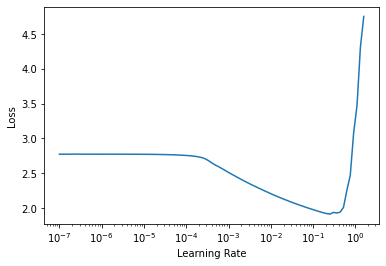

In [98]:
learn.lr_find()

In [99]:
learn.fit_one_cycle(2, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,1.542010,1.378696,0.292834,3.969723,00:42
1,1.508617,1.379864,0.294111,3.974362,00:42


## DNA Generation

In [103]:
learn.predict("CGCAT", n_words=10, temperature=1)[::2]

'CGCATGTTAGTGTAT'